In [3]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, "../models")

In [4]:
import dsprites_data
import DSprites
from DSprites import EarlyFactorVAE, FactorVAE
import torch
import numpy as np
import matplotlib.pyplot as plt
import configs
from torch.utils.data import DataLoader

In [5]:
#static variables

model_path = "../models/tmp/"
dataset_size = 10000

In [6]:
# load in dsprites data

dsprites_loader = dsprites_data.DSpritesLoader()

In [14]:
#utility functions

def parse_path_to_hparams(experiment_path, config):
    hparams = dict((x, eval(y)) for x,y in (experiment_path.split("/")[1].split("="),))
    return config._replace(hparams={**config.hparams, **hparams})


def create_dataset():
    dataset = DataLoader(dsprites_data.DSPritesIID(size=dataset_size, 
                                                   dsprites_loader=dsprites_loader,
                                                   ), batch_size=32)
    return dataset

## Latent traversals

In [9]:
experiment_path = "isvae/z_size=10/0"

config = parse_path_to_hparams(experiment_path, configs.isvae)

model = FactorVAE(**config.hparams)
model.load_state_dict(torch.load(model_path+experiment_path+".pt"))
model.train()

FactorVAE(
  (fc1): Linear(in_features=4096, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=9, bias=True)
  (fc3): Linear(in_features=1200, out_features=9, bias=True)
  (fc4): Linear(in_features=10, out_features=1200, bias=True)
  (fc5): Linear(in_features=1200, out_features=1200, bias=True)
  (fc6): Linear(in_features=1200, out_features=4096, bias=True)
  (z_prime_mu): Linear(in_features=1200, out_features=1, bias=True)
  (z_prime_logvar): Linear(in_features=1200, out_features=1, bias=True)
  (fc7): Linear(in_features=1, out_features=6, bias=True)
  (ce_loss): CrossEntropyLoss()
)

tensor([[-1.9661,  0.4830,  0.0501,  0.9541, -0.9478, -1.3453,  0.9191, -0.2898,
          1.8582, -0.3874]]) torch.Size([1, 10])


array([-1.9660585 ,  0.48304418,  0.05013569,  0.9540746 , -0.9478068 ,
       -1.3453388 ,  0.9191271 , -0.28982055,  1.8582109 , -0.38738966],
      dtype=float32)

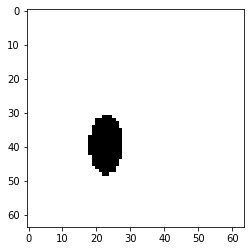

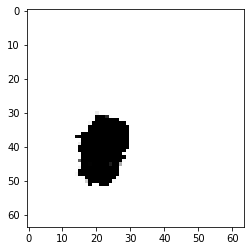

In [148]:
# sample around well defined point

data = create_dataset()
sample = next(iter(data))
sample = sample[0][0]

plt.imshow(sample.view(64, 64), cmap='Greys')
mu, _, mu_prime, _ = model.encode(sample.unsqueeze(dim=0))
z = torch.cat((mu, mu_prime), dim=1).detach().cpu()
print(z, z.shape)
# decode

plt.figure()
res_ = model.decode(z).detach()
plt.imshow(res_.view(64, 64), cmap='Greys')
z = z.squeeze().numpy()
z

(-0.5, 63.5, 63.5, -0.5)

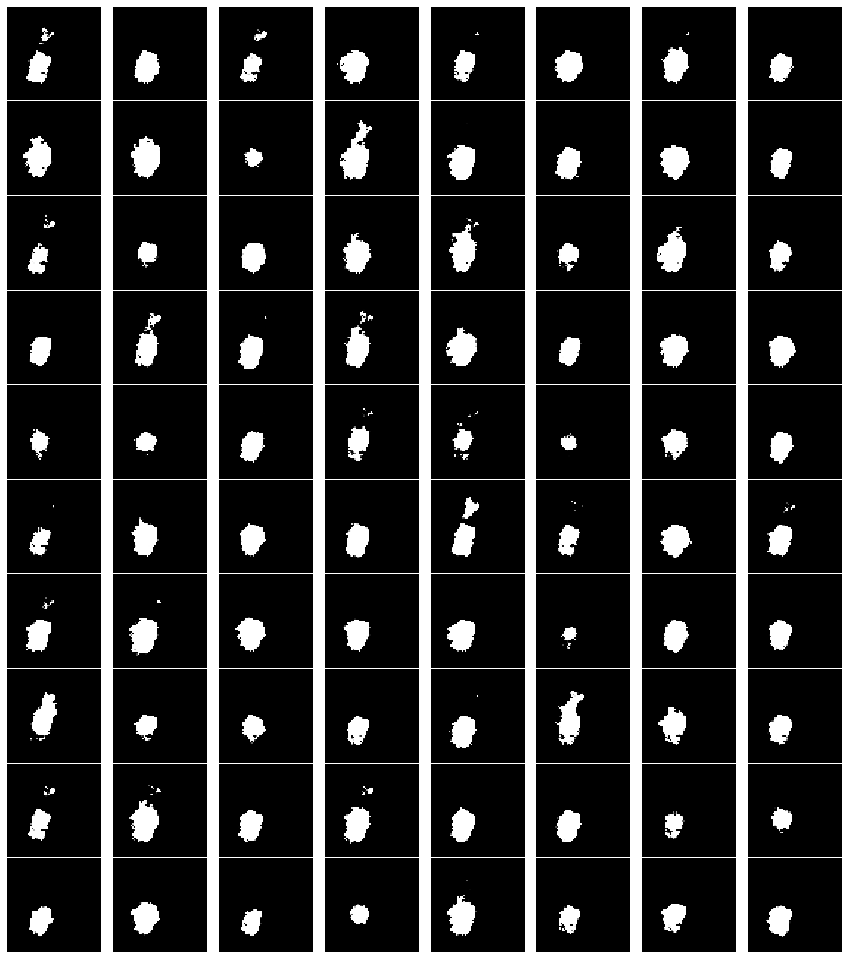

In [152]:
results = []

num_samples=8
for i in range(config.hparams['z_size']):
    samples = 0.5*np.random.randn(num_samples, config.hparams['z_size']).astype(np.float32)
    #     print(samples.shape, samples)
#     print("**")
#     print(samples+z)
    #     samples[:, i] = np.linspace(-1, 1, num=num_samples, dtype=np.float32)
    # print(samples)
    samples = samples+z
    samples = model.decode(torch.tensor(samples)).detach()
    results.append(samples)


fig, axes = plt.subplots(config.hparams['z_size'], num_samples)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.subplots_adjust(top=0.9, hspace=0.55)
for i in range(config.hparams['z_size']):
    for j in range(num_samples):
        x = results[i][j].view((-1, 64, 64)).squeeze().numpy()
        axes[i, j].imshow(x, cmap="Greys_r")
        axes[i, j].axis('off')
# plt.tight_layout()

plt.subplots_adjust(wspace=0.1, hspace=0.01, top=1)
plt.axis('off')

In [1]:
!nvidia-smi

Tue May 19 13:23:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.31       Driver Version: 440.31       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 206...  On   | 00000000:09:00.0 Off |                  N/A |
|  0%   39C    P8    15W / 175W |    148MiB /  7979MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  